In [1]:
# load libs
import torch
import argparse
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from data.datasets import MNIST
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
'''
@ Original 28x28 is rescaled to 32x32 to meet 2^P size
@ batch_size and workders can be increased for faster loading
'''
print(torch.__version__)
batch_size=1
test_batch_size=1
kwargs={}
train_loader=data_utils.DataLoader(MNIST(root='./data',train=True,process=False,transform=transforms.Compose([
    transforms.Scale((32,32)),
    transforms.ToTensor(),
])),batch_size=batch_size,shuffle=True,**kwargs)


test_loader=data_utils.DataLoader(MNIST(root='./data',train=False,process=False,transform=transforms.Compose([
    transforms.Scale((32,32)),
    transforms.ToTensor(),
])),batch_size=test_batch_size,shuffle=True,**kwargs)

0.2.0_4


In [5]:
'''
@ For demo use, only use first 1000 samples
'''
def create_numpy_dataset():
    datasets = []
    for data in train_loader:
        data_numpy = data[0].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)

    datasets = np.array(datasets)
    datasets=np.expand_dims(datasets,axis=1)
    print('Numpy dataset shape is {}'.format(datasets.shape))
    return datasets[:1000]

In [8]:
'''
@ return: augmented anchors
'''
def PCA_and_augment(data_in):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    print('PCA_and_augment: {}'.format(data.shape))
    # mean removal
    mean = np.mean(data, axis=0)
    datas_mean_remov = data - mean
    print('PCA_and_augment meanremove shape: {}'.format(datas_mean_remov.shape))

    # PCA, retain all components
    pca=PCA()
    pca.fit(datas_mean_remov)
    comps=pca.components_

    # augment, DC component doesn't
    comps_aug=[vec*(-1) for vec in comps[1:]]
    comps_complete=np.vstack((comps,comps_aug))
    print('PCA_and_augment comps_complete shape: {}'.format(comps_complete.shape))
    return comps_complete

In [21]:
'''
@ depth: determine shape, initial: 0
'''
from itertools import product
def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=32/factor
    print('fit_pca_shape: length: {}'.format(length))
    idx1=range(0,int(length),2)
    idx2=[i+2 for i in idx1]
    print('fit_pca_shape: idx1: {}'.format(idx1))
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape))

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print('fit_pca_shape: reshape: {}'.format(data.shape))
    return data

In [25]:
'''
@ Prepare shape changes. 
@ return filters for convolution
@ aug_anchors: [out_num*in_num,4] -> [out_num,in_num,2,2]
'''
def ret_filt_patches(aug_anchors,input_channels):
    shape=aug_anchors.shape[1]/4
    num=aug_anchors.shape[0]
    filt=np.reshape(aug_anchors,(int(num),int(shape),4))
    
    # reshape to kernels, (# output_channels,# input_channels,2,2)
    filters=np.reshape(filt,(int(num),int(shape),2,2))

    return filters

In [11]:
'''
@ input: kernel and data
@ output: conv+relu result
'''
def conv_and_relu(filters,datasets,stride=2):
    # torch data change
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)

    # Relu
    relu_output=F.relu(output)

    return relu_output,filt

In [22]:
'''
@ One-stage Saak transform
@ input: datasets [60000,channel,size,size]
'''
def one_stage_saak_trans(datasets=None,depth=0):


    # intial dataset, (60000,1,32,32)
    # channel change: 1->7
    print('one_stage_saak_trans: datasets.shape {}'.format(datasets.shape))
    input_channels=datasets.shape[1]

    # change data shape, (14*60000,4)
    data_flatten=fit_pca_shape(datasets,depth)
    
    # augmented components, first round: (7,4), only augment AC components
    comps_complete=PCA_and_augment(data_flatten)
    print('one_stage_saak_trans: comps_complete: {}'.format(comps_complete.shape))

    # get filter, (7,1,2,2) 
    filters=ret_filt_patches(comps_complete,input_channels)
    print('one_stage_saak_trans: filters: {}'.format(filters.shape))

    # output (60000,7,14,14)
    relu_output,filt=conv_and_relu(filters,datasets,stride=2)

    data=relu_output.data.numpy()
    print('one_stage_saak_trans: output: {}'.format(data.shape))
    return data,filt,relu_output


In [18]:
'''
@ Multi-stage Saak transform
'''
def multi_stage_saak_trans():
    filters = []
    outputs = []

    data=create_numpy_dataset()
    dataset=data
    num=0
    img_len=data.shape[-1]
    while(img_len>=2):
        num+=1
        img_len/=2


    for i in range(num):
        print('{} stage of saak transform: '.format(i))
        data,filt,output=one_stage_saak_trans(data,depth=i)
        filters.append(filt)
        outputs.append(output)
        print('')


    return dataset,filters,outputs

In [26]:
data,filters,outputs=multi_stage_saak_trans()

Numpy dataset shape is (60000, 1, 32, 32)
0 stage of saak transform: 
one_stage_saak_trans: datasets.shape (1000, 1, 32, 32)
fit_pca_shape: length: 32.0
fit_pca_shape: idx1: range(0, 32, 2)
fit_pca_shape: data_lattice.shape: (256, 1000, 1, 2, 2)
fit_pca_shape: reshape: (256000, 1, 2, 2)
PCA_and_augment: (256000, 4)
PCA_and_augment meanremove shape: (256000, 4)
PCA_and_augment comps_complete shape: (7, 4)
one_stage_saak_trans: comps_complete: (7, 4)
one_stage_saak_trans: filters: (7, 1, 2, 2)
one_stage_saak_trans: output: (1000, 7, 16, 16)

1 stage of saak transform: 
one_stage_saak_trans: datasets.shape (1000, 7, 16, 16)
fit_pca_shape: length: 16.0
fit_pca_shape: idx1: range(0, 16, 2)
fit_pca_shape: data_lattice.shape: (64, 1000, 7, 2, 2)
fit_pca_shape: reshape: (64000, 7, 2, 2)
PCA_and_augment: (64000, 28)
PCA_and_augment meanremove shape: (64000, 28)
PCA_and_augment comps_complete shape: (55, 28)
one_stage_saak_trans: comps_complete: (55, 28)
one_stage_saak_trans: filters: (55, 7, 2,

In [27]:
# show sample
def show_sample(data):
    plt.imshow(data)
    plt.gray()
    plt.show()

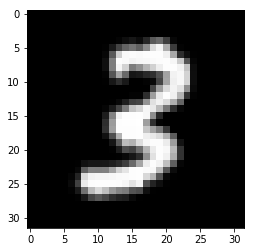

In [28]:
dat1=F.conv_transpose2d(outputs[0],filters[0],stride=2)
dat1=dat1.data.numpy()
show_sample(dat1[0][0])

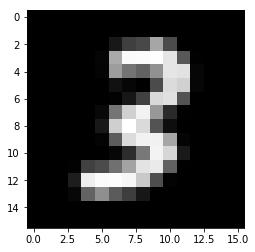

In [29]:
dat3=F.conv_transpose2d(outputs[1],filters[1],stride=2)
dat3=dat3.data.numpy()
show_sample(dat3[0][0])

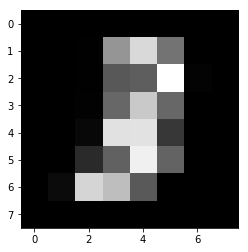

In [30]:
dat4=F.conv_transpose2d(outputs[2],filters[2],stride=2)
dat4=dat4.data.numpy()
show_sample(dat4[0][0])

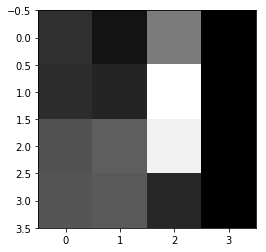

In [31]:
dat5=F.conv_transpose2d(outputs[3],filters[3],stride=2)
dat5=dat5.data.numpy()
show_sample(dat5[0][0])

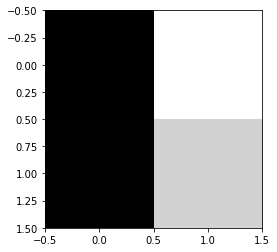

In [32]:
dat6=F.conv_transpose2d(outputs[4],filters[4],stride=2)
dat6=dat6.data.numpy()
show_sample(dat6[0][0])

In [33]:
'''
@ Reconstruct from second-last stage
@ In fact, can be from any stage
'''
def toy_recon(outputs,filters):
    outputs=outputs[::-1][1:]
    filters=filters[::-1][1:]
    num=len(outputs)
    data=outputs[0]
    for i in range(num):
        data = F.conv_transpose2d(data, filters[i], stride=2)

    return data

In [34]:
ret=toy_recon(outputs,filters)

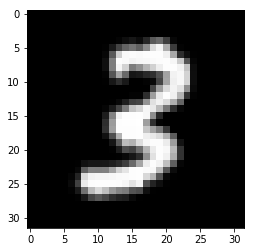

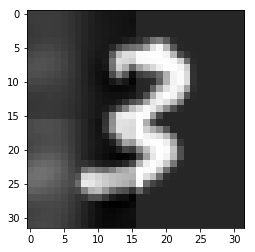

In [35]:
show_sample(data[0][0])
inv_img=ret.data.numpy()[0][0]
show_sample(inv_img)